#### Importação das bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import precision_score, recall_score, roc_auc_score, fbeta_score, make_scorer
from itertools import combinations, product
import plotly.graph_objects as go
import plotly.subplots as sp

import warnings
warnings.simplefilter(action='ignore')

seed = 2024

#### Leitura do Dataframe pós pré-processamento

In [2]:
df_athletes_activities = pd.read_csv('.../running_inactivity_prediction/df_athletes_activities.csv', parse_dates=['activity_date'])
df_athletes_activities

,activity_date,athlete_id,total_distance (km),total_time (min),pace (min/km),speed (km/h),week_frequency,week_total_time,week_max_time,week_total_dist,...,PR_pace,PR_speed,PR_days_since_last_act,PR_week_frequency,PR_week_total_time,PR_week_max_time,PR_week_total_dist,PR_week_max_dist,PR_week_best_pace,PR_week_best_speed
0,2020-07-09,1,6.03,39.0,6.47,9.28,1,39.0,39.0,6.03,...,6.47,9.28,0,1,39.0,39.0,6.03,6.03,6.47,9.28
1,2020-07-12,1,7.57,55.0,7.27,8.26,2,94.0,55.0,13.60,...,6.47,9.28,3,2,94.0,55.0,13.60,7.57,6.47,9.28
2,2020-07-16,1,3.61,23.0,6.37,9.42,2,78.0,55.0,11.18,...,6.37,9.42,4,2,94.0,55.0,13.60,7.57,6.37,9.42
3,2020-07-24,1,5.84,41.0,7.02,8.55,1,41.0,41.0,5.84,...,6.37,9.42,8,2,94.0,55.0,13.60,7.57,6.37,9.42
4,2020-07-25,1,4.28,32.0,7.48,8.02,2,73.0,41.0,10.12,...,6.37,9.42,8,2,94.0,55.0,13.60,7.57,6.37,9.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2024-06-16,7,10.06,45.0,4.47,13.26,3,95.0,45.0,18.83,...,4.36,13.77,5,5,190.0,70.0,35.81,13.24,4.36,13.77
740,2024-06-18,7,5.20,33.0,6.35,9.27,3,108.0,45.0,20.96,...,4.36,13.77,5,5,190.0,70.0,35.81,13.24,4.36,13.77
741,2024-06-21,7,12.10,62.0,5.12,11.71,3,140.0,62.0,27.36,...,4.36,13.77,5,5,190.0,70.0,35.81,13.24,4.36,13.77
742,2024-06-26,7,4.08,22.0,5.39,11.13,2,84.0,62.0,16.18,...,4.36,13.77,5,5,190.0,70.0,35.81,13.24,4.36,13.77


#### Dataframe com as features com coeficiente de correlação acima de 0.7

In [3]:
# Matriz de correlação entre as features, excluindo a data, id do atleta e o target
corr = df_athletes_activities.drop(['activity_date', 'athlete_id', 'inactivation'], axis = 1).corr(method='spearman')

# Transformar a matriz de correlação em um DataFrame (formatado de maneira que seja fácil visualizar pares de features)
df_corr = pd.melt(corr, ignore_index=False, var_name='feature2', value_name='correlation')

# Resetar o índice para que 'feature1' seja uma coluna em vez de índice e renomear a coluna de índice para 'feature1'
df_corr = df_corr.reset_index().rename(columns={'index': 'feature1'})

# Remover linhas onde 'feature1' e 'feature2' são iguais (ou seja, a correlação de uma feature com ela mesma)
df_corr.drop(df_corr[(df_corr['feature1'] == df_corr['feature2'])].index, axis=0, inplace=True)

# Remover duplicatas na coluna de correlação, mantendo apenas a primeira ocorrência
df_corr.drop_duplicates(subset='correlation', inplace=True)

# Resetar o índice mais uma vez após remover duplicatas
df_corr.reset_index(drop=True, inplace=True)

# Selecionando apenas correlações com valor acima de -0.7 ou 0.7 (Forte correlação)
df_strong_corr = df_corr[(np.abs(df_corr['correlation']) > 0.7)]

df_strong_corr

,feature1,feature2,correlation
0,total_time (min),total_distance (km),0.859980
41,speed (km/h),pace (min/km),-0.999630
47,week_best_pace,pace (min/km),0.821850
48,week_best_speed,pace (min/km),-0.821758
65,week_best_pace,speed (km/h),-0.821502
66,week_best_speed,speed (km/h),0.821826
78,week_total_time,week_frequency,0.920848
80,week_total_dist,week_frequency,0.928347
81,week_max_dist,week_frequency,0.755104
82,week_best_pace,week_frequency,-0.746167


#### Remoção das features multicolineares para evitar redundância
##### Em cada dupla, a feature com a maior correlação média absoluta com as outras, será removida.

In [4]:
# Cria um conjunto vazio para armazenar features a serem removidas
features_to_remove = set()

# Itera sobre cada linha do DataFrame df_strong_corr (Correlações fortes)
for i, row in df_strong_corr.iterrows():
    # Obtém o nome da primeira feature
    feature1 = row['feature1']

    # Obtém o nome da segunda feature
    feature2 = row['feature2']

    # Obtém as correlações da feature1 com as outras features
    feature1_corrs = df_corr.loc[(df_corr['feature1'] == feature1) | (df_corr['feature2'] == feature1)]

    # Obtém a média absoluta da correlação da feature1 com as outras features, exceto a feature2
    feature1_corrs_abs_mean = round(np.abs(feature1_corrs.loc[~feature1_corrs['feature2'].isin([feature2]), 'correlation']).mean(), 3)

    # Obtém as correlações da feature2 com as outras features
    feature2_corrs = df_corr.loc[(df_corr['feature1'] == feature2) | (df_corr['feature2'] == feature2)]

    # Obtém a média absoluta da correlação da feature2 com as outras features, exceto a feature1
    feature2_corrs_abs_mean = round(np.abs(feature2_corrs.loc[~feature2_corrs['feature1'].isin([feature1]), 'correlation']).mean(), 3)

    print(f'Feature 1: {feature1}, Média absoluta da correlação com outras features: {feature1_corrs_abs_mean}')
    print(f'Feature 2: {feature2}, Média absoluta da correlação com outras features: {feature2_corrs_abs_mean}')

    # Compara as correlações das duas features
    if feature1_corrs_abs_mean > feature2_corrs_abs_mean:
        print(f'Feature com maior correlação com as outras features: {feature1}')
        # Adiciona feature1 ao conjunto se sua correlação for maior
        features_to_remove.add(feature1)
    elif feature1_corrs_abs_mean < feature2_corrs_abs_mean:
        # Adiciona feature2 ao conjunto se sua correlação for maior
        print(f'Feature com maior correlação com as outras features: {feature2}')
        features_to_remove.add(feature2)

    print()

# Converte o conjunto para uma lista
features_to_remove = list(features_to_remove)

features_to_keep = [feature for feature in df_athletes_activities.drop(['athlete_id', 'activity_date', 'inactivation'], axis=1).columns.values if feature not in features_to_remove]

# Exibe a lista de features a serem removidas
print(f'Features removidas ({len(features_to_remove)}): {features_to_remove}')

# Exibe a list de features que irão pro modelo
print(f'Features mantidas ({len(features_to_keep)}): {features_to_keep}')

# Remove as features multicolineares selecionadas
df_athletes_activities.drop(features_to_remove, axis = 1, inplace= True)

Feature 1: total_time (min), Média absoluta da correlação com outras features: 0.314
Feature 2: total_distance (km), Média absoluta da correlação com outras features: 0.426
Feature com maior correlação com as outras features: total_distance (km)

Feature 1: speed (km/h), Média absoluta da correlação com outras features: 0.436
Feature 2: pace (min/km), Média absoluta da correlação com outras features: 0.435
Feature com maior correlação com as outras features: speed (km/h)

Feature 1: week_best_pace, Média absoluta da correlação com outras features: 0.578
Feature 2: pace (min/km), Média absoluta da correlação com outras features: 0.444
Feature com maior correlação com as outras features: week_best_pace

Feature 1: week_best_speed, Média absoluta da correlação com outras features: 0.578
Feature 2: pace (min/km), Média absoluta da correlação com outras features: 0.444
Feature com maior correlação com as outras features: week_best_speed

Feature 1: week_best_pace, Média absoluta da correlaç

#### Seleção das features

In [5]:
features = df_athletes_activities.drop(['activity_date', 'athlete_id','inactivation'], axis = 1).columns

all_features_comb = []
for r in range(1, len(features) + 1):
    combinations_r = list(combinations(features, r))
    # Exemplo1: combinations('ABCD', 1) → A B C D
    # Exemplo2: combinations('ABCD', 2) → AB AC AD BC BD CD
    all_features_comb.extend(combinations_r)     

all_features_comb_lists = [list(comb) for comb in all_features_comb]
print(f'Combinações possíveis de features: {len(all_features_comb_lists)}')

Combinações possíveis de features: 1023


#### Algoritmos de Aprendizado de Máquina selecionados

In [6]:
params = {'random_state': seed, 'class_weight': 'balanced'}
algorithms = [['Logistic Regression', LR(**params)], 
             ['Decision Tree', DT(**params)],
             ['Random Forest', RF(**params)]]

for algorithm in algorithms:
    print(f'{algorithm[0]}: {algorithm[1]}')

Logistic Regression: LogisticRegression(class_weight='balanced', random_state=2024)
Decision Tree: DecisionTreeClassifier(class_weight='balanced', random_state=2024)
Random Forest: RandomForestClassifier(class_weight='balanced', random_state=2024)


#### Produto cruzado entre as possibilidades de features e algoritmos

In [7]:
products = [dict(zip(('algorithm', 'features'), (i,j))) for i,j in product(algorithms, all_features_comb_lists)]
print(f'Combinações possíveis de modelos: {len(products)}')

Combinações possíveis de modelos: 3069


#### Divisão dos dados para treino e teste

In [8]:
X = df_athletes_activities.drop(['activity_date', 'athlete_id', 'inactivation'], axis = 1)
y = df_athletes_activities['inactivation']

# Separando dados para treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= seed, stratify=y)

print('Dados para treino e teste')
print(f'X_train shape : {X_train.shape}\ny_train shape: {y_train.value_counts()}')
print(f'X_test shape : {X_test.shape}\ny_test shape: {y_test.value_counts()}')

Dados para treino e teste
X_train shape : (595, 10)
y_train shape: inactivation
0    433
1    162
Name: count, dtype: int64
X_test shape : (149, 10)
y_test shape: inactivation
0    109
1     40
Name: count, dtype: int64


#### Função preditiva com validação cruzada nos dados de treino

In [9]:
def classification_function(X_train, y_train, algorithm, features):

    # Cria um scorer personalizado para o Fβ-score
    f2 = make_scorer(fbeta_score, beta=2)

    # Métricas avaliativas utilizadas
    scoring = {'precision':'precision', 'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc', 'f2': f2}

    # Configurando Stratified Cross Validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed) 

    # Cross-Validation
    results = cross_validate(estimator=algorithm[1], X= X_train[features], y= y_train, cv=cv, scoring= scoring, return_train_score=True, n_jobs=-1)

    metrics = {"Features": features,
               "Algorithm": algorithm[0],

               "Precision Train": round(results['train_precision'].mean(),3), 
               "Precision Eval": round(results['test_precision'].mean(),3),

               "Recall Train": round(results['train_recall'].mean(), 3), 
               "Recall Eval": round(results['test_recall'].mean(), 3),

               "F2 Train": round(results['train_f2'].mean(), 3), 
               "F2 Eval": round(results['test_f2'].mean(), 3),

               "AUC-ROC Train": round(results['train_roc_auc'].mean(), 3), 
               "AUC-ROC Eval": round(results['test_roc_auc'].mean(), 3)}    

    return metrics

#### Iteração da função principal

In [10]:
# Chamada da função principal com os dados de treino, algoritmo e features e adicionando em lista de resultados
results = [classification_function(X_train, y_train, product['algorithm'], product['features']) for product in products]

#### Dataframe com todos os modelos resultados através das combinações

In [11]:
df_results = pd.DataFrame(results)
df_results.sort_values('F2 Eval', ascending= False).reset_index(drop=True)

,Features,Algorithm,Precision Train,Precision Eval,Recall Train,Recall Eval,F2 Train,F2 Eval,AUC-ROC Train,AUC-ROC Eval
0,"[total_time (min), week_max_time, days_since_l...",Logistic Regression,0.579,0.584,0.799,0.815,0.743,0.755,0.840,0.833
1,"[total_time (min), days_since_last_act, PR_tot...",Logistic Regression,0.594,0.596,0.799,0.802,0.748,0.751,0.859,0.847
2,"[total_time (min), days_since_last_act, PR_tot...",Logistic Regression,0.576,0.585,0.796,0.809,0.740,0.751,0.832,0.824
3,"[total_time (min), days_since_last_act, PR_tot...",Logistic Regression,0.576,0.585,0.796,0.809,0.740,0.751,0.832,0.824
4,"[total_time (min), days_since_last_act, PR_wee...",Logistic Regression,0.594,0.596,0.799,0.802,0.748,0.751,0.859,0.847
...,...,...,...,...,...,...,...,...,...,...
3064,"[total_time (min), pace (min/km), week_max_tim...",Decision Tree,0.988,0.474,1.000,0.457,0.998,0.459,1.000,0.633
3065,"[total_time (min), pace (min/km), week_max_tim...",Decision Tree,1.000,0.488,1.000,0.451,1.000,0.457,1.000,0.636
3066,"[total_time (min), week_max_time, days_since_l...",Random Forest,0.944,0.528,0.985,0.438,0.976,0.453,0.997,0.792
3067,"[total_time (min), pace (min/km), week_max_tim...",Random Forest,0.985,0.598,1.000,0.414,0.997,0.441,0.999,0.804


#### Atribuição dos resultados para uma planilha

In [12]:
df_results.to_excel('.../models_results.xlsx', index = False)

#### Análise de cada métrica avaliativa dos modelos resultados para cada algoritmo 

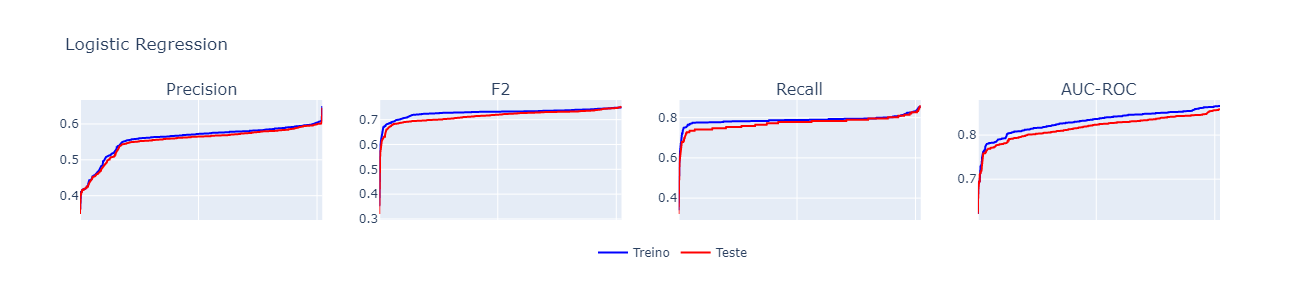

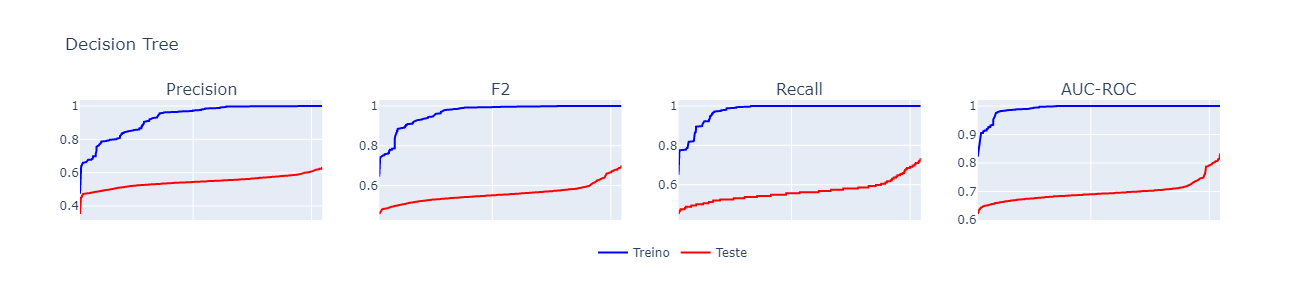

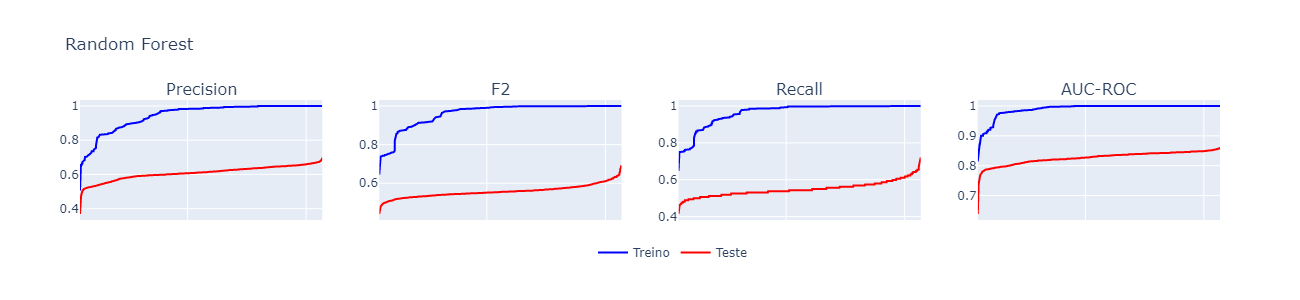

In [13]:
# Função para criar o gráfico de linhas para as métricas
def plot_metrics(metrics, algorithm):

    df = df_results[df_results['Algorithm'].isin([algorithm])].copy()

    # Criando a figura com 1 linha e 4 colunas
    fig = sp.make_subplots(rows=1, cols=4, subplot_titles=metrics)
    
    # Adicionando os gráficos de cada métrica
    for i, metric in enumerate(metrics, start=1):
        fig.add_trace(go.Scatter(x=df.index, y=df[f'{metric} Train'].sort_values(),
                                 mode='lines', name='Treino', line=dict(color='blue'), showlegend=(i == 1)),
                      row=1, col=i)
        
        fig.add_trace(go.Scatter(x=df.index, y=df[f'{metric} Eval'].sort_values(),
                                 mode='lines', name='Teste', line=dict(color='red'), showlegend=(i == 1)),
                      row=1, col=i)
        
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=True)

    # Configurações do layout para uma única legenda
    fig.update_layout(height=300, width=1300, title=algorithm, legend=dict(x=0.45, y=-0.15, orientation='h'))
    
    fig.show('png')

# Lista de métricas
metrics = ['Precision', 'F2', 'Recall', 'AUC-ROC']

# Gerando os gráficos para todas as métricas
for alg_name, alg_value in algorithms:
    plot_metrics(metrics, alg_name)

#### Avaliação final

In [14]:
def scores(y_true, y_pred):

    return {'Precision Test': round(precision_score(y_true, y_pred), 3), 
            'Recall Test': round(recall_score(y_true, y_pred), 3), 
            'F2 Test': round(fbeta_score(y_true, y_pred, beta=2), 3), 
            'AUC-ROC Test': round(roc_auc_score(y_true, y_pred), 3)}

In [15]:
# Melhor modelo
df_results.sort_values('F2 Eval', ascending= False).iloc[0]

Features           [total_time (min), week_max_time, days_since_l...
Algorithm                                        Logistic Regression
Precision Train                                                0.579
Precision Eval                                                 0.584
Recall Train                                                   0.799
Recall Eval                                                    0.815
F2 Train                                                       0.743
F2 Eval                                                        0.755
AUC-ROC Train                                                   0.84
AUC-ROC Eval                                                   0.833
Name: 726, dtype: object

In [16]:
# Algoritmo do melhor modelo
best_algorithm = algorithms[0][1]

# Features do melhor modelo
best_features = ['total_time (min)', 'week_max_time', 'days_since_last_act', 'PR_week_max_dist', 'PR_week_best_pace', 'PR_week_best_speed']

# Treino e predição
best_algorithm.fit(X_train[best_features], y_train)
y_pred = best_algorithm.predict(X_test[best_features])

# Avaliação final
scores(y_test, y_pred)

{'Precision Test': 0.623,
 'Recall Test': 0.825,
 'F2 Test': 0.775,
 'AUC-ROC Test': 0.821}